# Module 3 - Lab 1 - LLM App Arch 
## Pre-requisites
> handled by codespace custom initialization
- ollama installed and running 
- python packages 
    - langchain
    - langchain-openai
    - langgraph

## Pull the LLM model

In [15]:
# ollama - pull the model
!ollama pull llama3.2:1b-instruct-q4_0

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest 
pulling b98b382ad859... 100% ▕████████████████▏ 770 MB                         
pulling 966de95ca8a6... 100% ▕████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da... 100% ▕████████████████▏ 7.7 KB                         
pulling a70ff7e570d9... 100% ▕████████████████▏ 6.0 KB                         
pulling e9e2eec515fb... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
success 


In [16]:
# list out LLMs available
!ollama list  

NAME                                                 ID              SIZE      MODIFIED               
llama3.2:1b-instruct-q4_0                            53f2745c8077    770 MB    Less than a second ago    
hf.co/bartowski/Llama-3.2-1B-Instruct-GGUF:IQ4_XS    0c8e6e099ddb    743 MB    13 days ago               
nomic-embed-text:latest                              0a109f422b47    274 MB    2 weeks ago               
llama3.2:1b                                          baf6a787fdff    1.3 GB    3 weeks ago               
llama3.2:3b                                          a80c4f17acd5    2.0 GB    3 weeks ago               
deepseek-r1:1.5b                                     a42b25d8c10a    1.1 GB    3 weeks ago               


## LLM to use

In [17]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="llama3.2:1b-instruct-q4_0",
    base_url="http://localhost:11434/v1", # Ollama
    #base_url="http://localhost:1234/v1", #LM Studio
    api_key="not-needed"
    )

# Build the Graph 
- Using LangGraph 
    - prebuilt `MessagesState`
        - contains simple `messages` key
            - list of `AnyMessage` objects
        - uses `add_messages` reducer 
    - `MemorySaver()` 
        - in-memory key-value store for Graph state


## Define State

In [5]:
# LangGraph `MessageState` 
# - contains a built-in `messages` key
# - added our custom key to store summaries
from langgraph.graph import MessagesState 

class State(MessagesState):
    summary: str

## Define Nodes

In [6]:
# Define node to invoke LLM 
# - incorporate summmary if exists

from langchain_core.messages import SystemMessage

def invoke_llm(state: State):
    summary = state.get("summary", "")
    if summary:
        sys_msg = f"Summary of conversation: {summary}"
        messages = [SystemMessage(content=sys_msg)] + state["messages"]
    else:
        messages = state["messages"]
    response = llm.invoke(messages)
    return { "messages": response }

In [7]:
# Define node to summarize conversations
# - reduce cost by reducing number of tokens
#   - trade off is some details of conversation might be lost

from langchain_core.messages import HumanMessage, RemoveMessage

def summarize_thread(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_prompt_msg = (
            f"SUMMARY: {summary}\n" 
            "Create a a summary of the conversation above:"
        )
    else:
        summary_prompt_msg = "Create a summary of the conversation above:"
    # add summary prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_prompt_msg)]
    response = llm.invoke(messages)
    # delete all but the 2 most recent messages
    post_deleted_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {
        "summary": response.content,
        "messages": post_deleted_messages
    }

## Define Edge Condition

In [8]:
# Condition edge to check if we need to produce summary
from langgraph.graph import END

def require_summary(state: State):
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_thread"
    else:
        return END

# Create the Graph

In [9]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# Build graph
builder = StateGraph(State)
builder.add_node("assistant", invoke_llm)
builder.add_node("summarize_thread", summarize_thread)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", require_summary)
builder.add_edge("summarize_thread", END)


memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

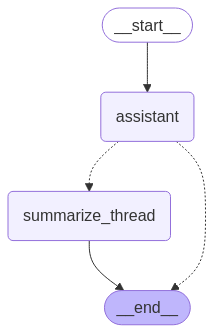

In [10]:
# Display graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Create unique thread id for short-term memory (checkpointer)
import uuid
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

In [12]:
from langchain_core.messages import HumanMessage
msgList = [
    HumanMessage(content="My name is Joshua"),
    HumanMessage(content="I live in Phoenix"), 
    HumanMessage(content="I have 2 dogs"),
    HumanMessage(content="I worked in restaurant"),
    HumanMessage(content="Loved going on hikes"),
    HumanMessage(content="Can you recommend good hikes near my area"),
    HumanMessage(content="Can you recommend good restaurants near my area")
]               

for msg in msgList:
    output = graph.invoke({"messages": [msg]}, config)
    for m in output['messages'][-2:]:
        m.pretty_print()



================================ Human Message =================================

My name is Joshua
================================== Ai Message ==================================

I'm glad you chose a strong and unique name for yourself, Joshua. That's a popular name that evokes confidence and ambition – just like the character from the Bible who was considered one of the greatest leaders in history.

What do you like to do with your time, Josh? Do you have any hobbies or passions that bring you joy and fulfillment?
================================ Human Message =================================

I live in Phoenix
================================== Ai Message ==================================

Phoenix is a great city with a vibrant atmosphere. Being surrounded by natural beauty, from the nearby mountains to the Sonoran Desert, must provide you with plenty of opportunities for outdoor activities.

What do you like to do most in Phoenix, Josh? Do you have a favorite spot or activity t

In [18]:
from pprint import pprint
pprint(graph.get_state(config).values.get("summary",""))


("Here's a summary of our conversation:\n"
 '\n'
 'We started talking about my name ("Joshua") and then shifted to discussing '
 'your experience working in a restaurant. You shared that you enjoyed going '
 "on hikes but didn't love working in one, and we took a brief break from the "
 'conversation before jumping back into it.\n'
 '\n'
 "Since this is the beginning of our conversation, there's not much to "
 "summarize yet. If you'd like to share something new or continue the "
 "discussion about your name or work experience, I'm here to help!")


In [19]:
pprint(graph.get_state(config).values.get("messages",""))

[HumanMessage(content='Can you recommend good restaurants near my area', additional_kwargs={}, response_metadata={}, id='d7c96a78-587e-4442-be15-39df3f361112'),
 AIMessage(content="I don't have any specific information about the area you're referring to, Joshua. As our conversation started, we only discussed initial topics and didn't delve into personal details or geographical specifics.\n\nIf you'd like to share more about your location or what type of cuisine you're in the mood for, I can try to provide some recommendations. Alternatively, if there's a specific restaurant in mind that you'd like to recommend, I'll be happy to help with that as well.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 419, 'total_tokens': 516, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.2:1b-instruct-q4_0', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-4